In [14]:
import numpy as np
import pandas as pd
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator

folder_path = '/Users/dipeshkumar/Documents/NOTES/Deep-Learning/utkface/utkface_aligned_cropped/UTKFace'

age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(os.path.join(folder_path, file))

# Check the lengths to ensure they are equal
print(len(age), len(gender), len(img_path))

# Create DataFrame
df = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})


23708 23708 23708


In [15]:
df.head()

,age,gender,img
0,9,1,/Users/dipeshkumar/Documents/NOTES/Deep-Learni...
1,36,0,/Users/dipeshkumar/Documents/NOTES/Deep-Learni...
2,86,1,/Users/dipeshkumar/Documents/NOTES/Deep-Learni...
3,26,1,/Users/dipeshkumar/Documents/NOTES/Deep-Learni...
4,1,1,/Users/dipeshkumar/Documents/NOTES/Deep-Learni...


In [16]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [17]:
train_df.shape

(20000, 3)

In [18]:
test_df.shape

(3708, 3)

In [19]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                              directory = folder_path,
                                              x_col = 'img',
                                              y_col = ['age','gender'],
                                              target_size=(200,200),
                                              class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                              directory = folder_path,
                                              x_col = 'img',
                                              y_col = ['age','gender'],
                                              target_size=(200,200),
                                              class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [23]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [24]:
vggnet = VGG16(include_top=False, input_shape=(200,200,3))

In [26]:
vggnet.trainable=False

output = vggnet.layers[-1].output
flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name = 'gender')(dense4)

In [27]:
model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

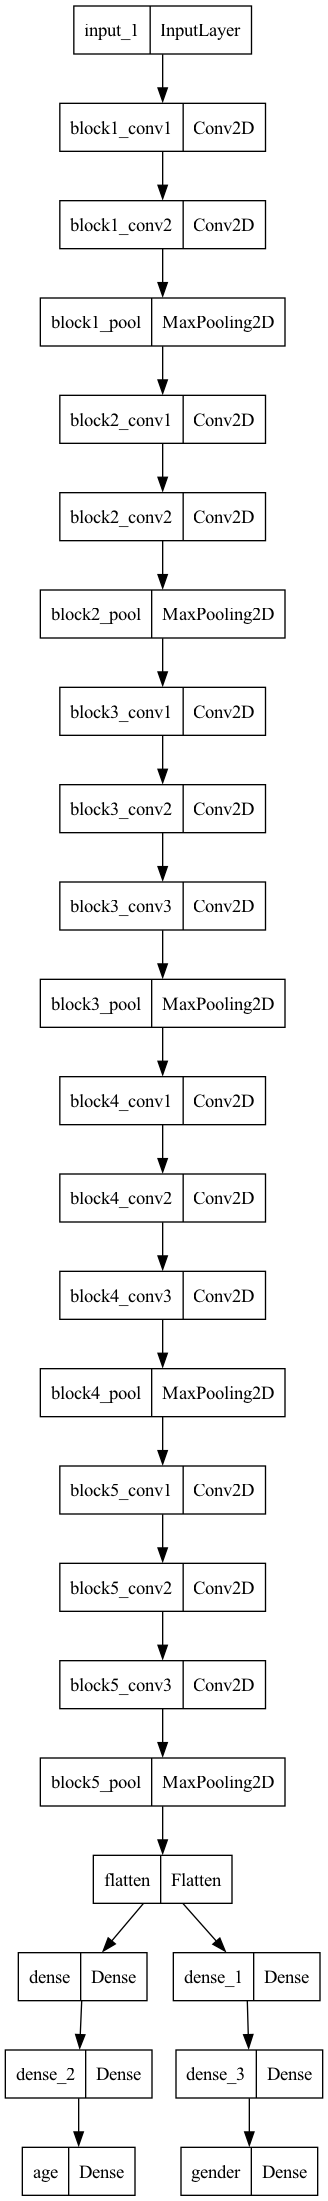

In [29]:
from keras.utils import plot_model
plot_model(model)

In [31]:
model.compile(optimizer='adam',loss={'age': 'mae','gender': 'binary_crossentropy'},metrics={'age': 'mae', 'gender':'accuracy'})

In [ ]:
model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)